In [1]:
import gc
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold
from hyperopt import STATUS_OK, tpe, hp, Trials, fmin
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
lgb_300_preds = pd.read_csv('./new_features2/lgb_300features_1000.csv', index_col='seg_id')
lgb_500_preds = pd.read_csv('./new_features2/lgb_500features_1000.csv', index_col='seg_id')
lgb_700_preds = pd.read_csv('./new_features2/lgb_700features_1000.csv', index_col='seg_id')
lgb_gb300_preds = pd.read_csv('./new_features2/lgb_gb300features_1000.csv', index_col='seg_id')
xgb_500_preds = pd.read_csv('./new_features2/xgb_500features_1000.csv', index_col='seg_id')

In [3]:
oof_lgb_300 = pd.read_csv('./new_features2/oof_lgb_300features_1000.csv', index_col='Unnamed: 0')
oof_lgb_500 = pd.read_csv('./new_features2/oof_lgb_500features_1000.csv')
oof_lgb_700 = pd.read_csv('./new_features2/oof_lgb_700features_1000.csv')
oof_lgb_gb300 = pd.read_csv('./new_features2/oof_lgb_gb300features_1000.csv', index_col='Unnamed: 0')
oof_xgb_500 = pd.read_csv('./new_features2/oof_xgb_500features_1000.csv', index_col='Unnamed: 0')

In [4]:
y = pd.read_csv('./new_features2/y.csv')

In [6]:
oof_lgb_300 = oof_lgb_300.values.reshape((6291,))
oof_lgb_500 = oof_lgb_500.values.reshape((6291,))
oof_lgb_700 = oof_lgb_700.values.reshape((6291,))
oof_lgb_gb300 = oof_lgb_gb300.values.reshape((6291,))
oof_xgb_500 = oof_xgb_500.values.reshape((6291,))

In [9]:
lgb_300_preds = lgb_300_preds.time_to_failure.values.reshape((2624,))
lgb_500_preds = lgb_500_preds.time_to_failure.values.reshape((2624,))
lgb_700_preds = lgb_700_preds.time_to_failure.values.reshape((2624,))
lgb_gb300_preds = lgb_gb300_preds.time_to_failure.values.reshape((2624,))
xgb_500_preds = xgb_500_preds.time_to_failure.values.reshape((2624,))

In [10]:
stack_list = [oof_lgb_300, oof_lgb_500, oof_lgb_700, oof_lgb_gb300, oof_xgb_500]
pred_list = [lgb_300_preds, lgb_500_preds, lgb_700_preds, lgb_gb300_preds, xgb_500_preds]
columns = ['lgb_300', 'lgb_500', 'lgb_700', 'lgb_gb300', 'xgb_500']
train_stack = pd.DataFrame(np.vstack(stack_list).transpose(), columns=columns)
test_stack = pd.DataFrame(np.vstack(pred_list).transpose(), columns=columns)

In [11]:
train_stack.shape

(6291, 5)

In [12]:
y.shape

(6291, 1)

In [14]:
NUM_EVALS = 1000
N_FOLDS = 5
XGB_MAX_LEAVES = 2**12 
XGB_MAX_DEPTH = 50
EVAL_METRIC_XGB_REG = 'mae'
LGBM_MAX_LEAVES = 2**11
LGBM_MAX_DEPTH = 35
EVAL_METRIC_LGBM_REG = 'mae'

In [16]:
def quick_hyperopt(data, labels, package='xgb', num_evals=NUM_EVALS, diagnostic=False):

    #==========
    #XGBoost
    #==========
    
    if package=='xgb':
        
        print('Running {} rounds of XGBoost parameter optimisation:'.format(num_evals))
        #clear space
        gc.collect()
        
        integer_params = ['max_depth']
        
        def objective(space_params):
            
            for param in integer_params:
                space_params[param] = int(space_params[param])
                
            #extract multiple nested tree_method conditional parameters
            #libera te tutemet ex inferis
            if space_params['tree_method']['tree_method'] == 'hist':
                max_bin = space_params['tree_method'].get('max_bin')
                space_params['max_bin'] = int(max_bin)
                if space_params['tree_method']['grow_policy']['grow_policy']['grow_policy'] == 'depthwise':
                    grow_policy = space_params['tree_method'].get('grow_policy').get('grow_policy').get('grow_policy')
                    space_params['grow_policy'] = grow_policy
                    space_params['tree_method'] = 'hist'
                else:
                    max_leaves = space_params['tree_method']['grow_policy']['grow_policy'].get('max_leaves')
                    space_params['grow_policy'] = 'lossguide'
                    space_params['max_leaves'] = int(max_leaves)
                    space_params['tree_method'] = 'hist'
            else:
                space_params['tree_method'] = space_params['tree_method'].get('tree_method')
                
            #for classification replace EVAL_METRIC_XGB_REG with EVAL_METRIC_XGB_CLASS
            cv_results = xgb.cv(space_params, train, num_boost_round=100, nfold=N_FOLDS, metrics=[EVAL_METRIC_XGB_REG],
                             early_stopping_rounds=100, stratified=False, seed=42)
            
            best_loss = cv_results['test-mae-mean'].iloc[-1] #or 'test-rmse-mean' if using RMSE
            #for classification, comment out the line above and uncomment the line below:
            #best_loss = 1 - cv_results['test-auc-mean'].iloc[-1]
            #if necessary, replace 'test-auc-mean' with 'test-[your-preferred-metric]-mean'
            return{'loss':best_loss, 'status': STATUS_OK }
        
        train = xgb.DMatrix(data, labels)
        
        #integer and string parameters, used with hp.choice()
        boosting_list = ['gbtree', 'gblinear'] #if including 'dart', make sure to set 'n_estimators'
        metric_list = ['mae'] 
        #for classification comment out the line above and uncomment the line below
        #metric_list = ['auc']
        #modify as required for other classification metrics classification
        
        tree_method = [{'tree_method' : 'exact'},
               {'tree_method' : 'approx'},
               {'tree_method' : 'hist',
                'max_bin': hp.quniform('max_bin', 2**3, 2**7, 1),
                'grow_policy' : {'grow_policy': {'grow_policy':'depthwise'},
                                'grow_policy' : {'grow_policy':'lossguide',
                                                  'max_leaves': hp.quniform('max_leaves', 32, XGB_MAX_LEAVES, 1)}}}]
        
        #if using GPU, replace 'exact' with 'gpu_exact' and 'hist' with
        #'gpu_hist' in the nested dictionary above
        
        objective_list_reg = ['reg:linear']
        objective_list_class = ['reg:logistic', 'binary:logistic']
        #for classification change line below to 'objective_list = objective_list_class'
        objective_list = objective_list_reg
        
        space ={'boosting' : hp.choice('boosting', boosting_list),
                'tree_method' : hp.choice('tree_method', tree_method),
                'max_depth': hp.quniform('max_depth', 2, XGB_MAX_DEPTH, 1),
                'reg_alpha' : hp.uniform('reg_alpha', 0, 5),
                'reg_lambda' : hp.uniform('reg_lambda', 0, 5),
                'min_child_weight' : hp.uniform('min_child_weight', 0, 5),
                'gamma' : hp.uniform('gamma', 0, 5),
                'learning_rate' : hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
                'eval_metric' : hp.choice('eval_metric', metric_list),
                'objective' : hp.choice('objective', objective_list),
                'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1, 0.01),
                'colsample_bynode' : hp.quniform('colsample_bynode', 0.1, 1, 0.01),
                'colsample_bylevel' : hp.quniform('colsample_bylevel', 0.1, 1, 0.01),
                'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
                'nthread' : 3
            }
        
        trials = Trials()
        best = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=num_evals, 
                    trials=trials)
        
        best['tree_method'] = tree_method[best['tree_method']]['tree_method']
        best['boosting'] = boosting_list[best['boosting']]
        best['eval_metric'] = metric_list[best['eval_metric']]
        best['objective'] = objective_list[best['objective']]
        
        #cast floats of integer params to int
        for param in integer_params:
            best[param] = int(best[param])
        if 'max_leaves' in best:
            best['max_leaves'] = int(best['max_leaves'])
        if 'max_bin' in best:
            best['max_bin'] = int(best['max_bin'])
        
        print('{' + '\n'.join('{}: {}'.format(k, v) for k, v in best.items()) + '}')
        
        if diagnostic:
            return(best, trials)
        else:
            return(best)

In [17]:
xgb_params2 = quick_hyperopt(train_stack, y, 'xgb', 1000, diagnostic=False)

Running 1000 rounds of XGBoost parameter optimisation:
100%|█| 1000/1000 [56:55<00:00,  2.87s/it, best loss: 1.9197564]         
{boosting: gbtree
colsample_bylevel: 0.71
colsample_bynode: 0.64
colsample_bytree: 0.96
eval_metric: mae
gamma: 1.8190608987635866
learning_rate: 0.029614976191358323
max_bin: 104
max_depth: 5
max_leaves: 3535
min_child_weight: 3.6940583804767675
objective: reg:linear
reg_alpha: 0.44296909713462196
reg_lambda: 3.1225037256463923
subsample: 0.9500000000000001
tree_method: hist}


In [18]:
xgb_params2

{'boosting': 'gbtree',
 'colsample_bylevel': 0.71,
 'colsample_bynode': 0.64,
 'colsample_bytree': 0.96,
 'eval_metric': 'mae',
 'gamma': 1.8190608987635866,
 'learning_rate': 0.029614976191358323,
 'max_bin': 104,
 'max_depth': 5,
 'max_leaves': 3535,
 'min_child_weight': 3.6940583804767675,
 'objective': 'reg:linear',
 'reg_alpha': 0.44296909713462196,
 'reg_lambda': 3.1225037256463923,
 'subsample': 0.9500000000000001,
 'tree_method': 'hist'}

In [19]:
MAE = 0
stack_preds = np.zeros(len(test_stack))
feature_importance_stack = pd.DataFrame()
scores = []

n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=0)
for fold, (train_idx, valid_idx) in enumerate(folds.split(train_stack)):
    X_train, y_train = train_stack.iloc[train_idx], y.iloc[train_idx]
    X_valid, y_valid = train_stack.iloc[valid_idx], y.iloc[valid_idx]
    model = xgb.XGBRegressor(**xgb_params2, n_estimators=20000, n_jobs=3)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)],
              verbose=10000, early_stopping_rounds=200)
    val_pred = model.predict(X_valid)
    fold_importance = pd.DataFrame()
    fold_importance['feature'] = train_stack.columns
    fold_importance['importance'] = model.feature_importances_
    fold_importance['fold'] = fold + 1
    MAE += mean_absolute_error(y_valid, val_pred) / n_fold
    stack_preds += model.predict(test_stack) / n_fold
    feature_importance_stack = pd.concat([feature_importance_stack, fold_importance], axis=0)
    scores.append(mean_absolute_error(y_valid, val_pred))
    
print('CV score: {}, std: {}'.format(MAE, np.std(scores)))

[0]	validation_0-mae:5.10124	validation_1-mae:4.9153
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[103]	validation_0-mae:1.84249	validation_1-mae:1.92839

[0]	validation_0-mae:5.02794	validation_1-mae:5.21127
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[91]	validation_0-mae:1.84671	validation_1-mae:1.94321

[0]	validation_0-mae:5.02189	validation_1-mae:5.22877
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[96]	validation_0-mae:1.834	validation_1-mae:1.97235

[0]	validation_0-mae:5.07778	validation_1-mae:5.00586
Multiple eval metrics have been passed: 'validation_1-mae' will be

In [20]:
submission = pd.read_csv('D:/kaggle/earthquake/sample_submission.csv', index_col='seg_id')
submission.time_to_failure = stack_preds
submission.to_csv('./new_features2/stack_lgb_xgb.csv', index=True)

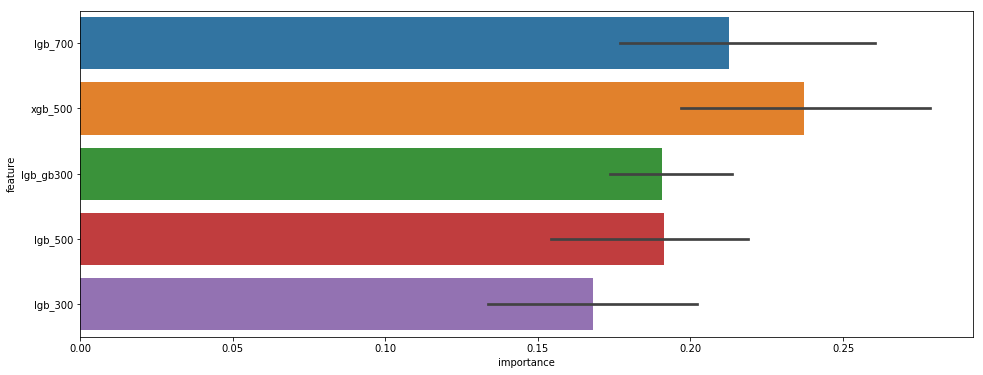

In [21]:
fig = plt.figure(figsize=(16, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_stack.sort_values(by='importance', ascending=False))
plt.show()